In [1]:
import os
import numpy as np
import rasterio
import rasterio.plot

from shapely.geometry import shape
from shapely.geometry.polygon import Polygon

from microsoft_planetarycomputer_download.utils import read_geojson
from utils.rasterio_utils import reproject_raster, mask_raster_by_shapely, save_raster_preview_as_png

In [70]:
dsm = '/data/chesapeake_bay_lulc/outputs/preprocessed/epsg-32618/virginia_beach_false_cape_landing/dsm/2.0/mosaic.tiff'
dem_1m = '/data/chesapeake_bay_lulc/outputs/preprocessed/epsg-32618/virginia_beach_false_cape_landing/dem/2.0/mosaic.tiff'

In [71]:
with rasterio.open(dsm) as src:
    dsm = src.read()

with rasterio.open(dem_1m) as src:
    dem = src.read()
    print(src.meta)

print(dsm.shape, dem.shape, dem.dtype)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -999999.0, 'width': 4971, 'height': 8151, 'count': 1, 'crs': CRS.from_epsg(32618), 'transform': Affine(2.0, 0.0, 414718.24472916755,
       0.0, -2.0, 4063451.84280604)}
(1, 8151, 4971) (1, 8151, 4971) float32


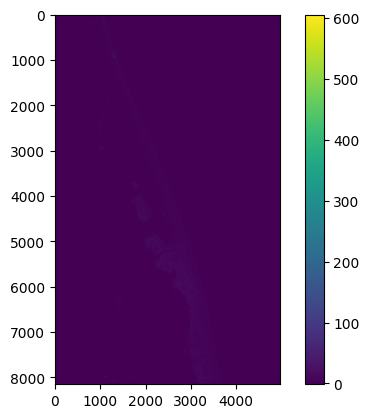

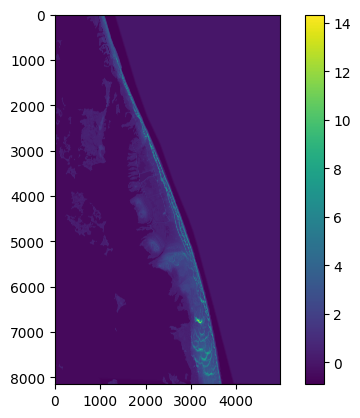

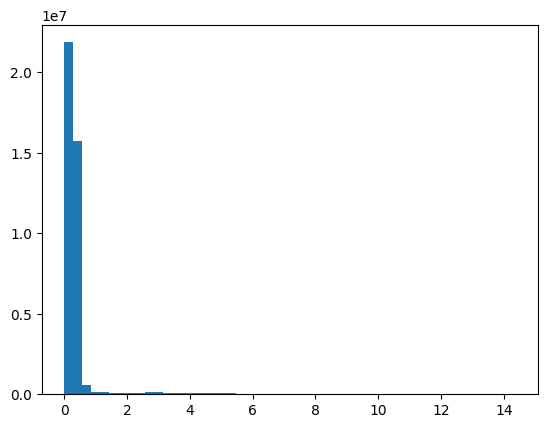

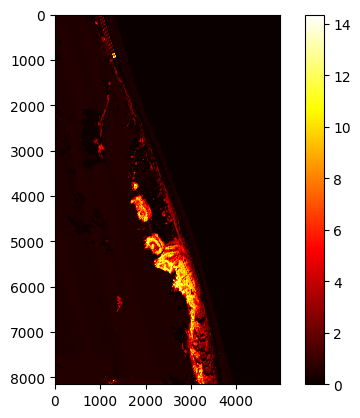

In [72]:
import matplotlib.pyplot as plt

dsm[dsm <= -9999] = 0
dem[dem <= -9999] = 0
print()
# dsm = np.clip(dsm, 0, 100)
plt.figure()
plt.imshow(dsm[0])
plt.colorbar()
plt.show()

# dem = np.clip(dem, 0, None)
plt.figure()
plt.imshow(dem[0])
plt.colorbar()
plt.show()

diff = dsm - dem
diff = np.clip(diff, 0, np.percentile(diff, 99.9))
plt.figure()
plt.hist(diff[0].flatten(), bins=50)
plt.show() 

plt.figure()
plt.imshow(diff[0], cmap='hot')
plt.colorbar()
plt.show()

In [2]:
def plot_and_info(path):
    with rasterio.open(path, 'r') as x:
        print(x.res, x.crs, x.nodata, x.crs.linear_units)
        rasterio.plot.show(x)

In [3]:
# plot_and_info('/data/chesapeake_bay_lulc/raw_tifs/lc/clin_42035_landcover_2013.tif')
# plot_and_info('/data/chesapeake_bay_lulc/chesapeake_data/de_1m_2013_extended-train_tiles/m_3807513_nw_18_1_naip-old.tif')

# plot_and_info('/data/chesapeake_bay_lulc/chesapeake_data/de_1m_2013_extended-train_tiles/m_3807523_ne_18_1_lc.tif')
# plot_and_info('/data/chesapeake_bay_lulc/chesapeake_data/de_1m_2013_extended-train_tiles/m_3807523_ne_18_1_nlcd.tif')

# plot_and_info('/data/chesapeake_bay_lulc/chesapeake_data/de_1m_2013_extended-train_tiles/m_3807523_sw_18_1_landsat-leaf-on.tif')


In [6]:
data_dir = '/data/chesapeake_bay_lulc/'

# replace for virginia_beach geojsons
geojson_filepath = '/home/connor/repos/aerial-auto-segment/geojsons/clinton.geojson'
# replace for virginia_beach label rasters
label_raster = '/data/chesapeake_bay_lulc/raw_tifs/lc/clin_42035_landcover_2017.tif'

save_dir = os.path.join(data_dir, 'chesapeake_bay_lc', os.path.basename(geojson_filepath).split('.')[0], 'mosaic')
bounds = Polygon(shape(read_geojson(geojson_filepath)['geometry']))

reprojected_label_raster = label_raster.replace('.tif', '_epsg4326.tif')
final_mosaic_path = os.path.join(save_dir, 'mosaic.tiff')

with rasterio.open(label_raster, 'r') as x:
    original_crs = x.crs

os.makedirs(save_dir, exist_ok=True)
reproject_raster(label_raster, reprojected_label_raster, 'EPSG:4326')
mask_raster_by_shapely(reprojected_label_raster, final_mosaic_path, bounds)
reproject_raster(final_mosaic_path, final_mosaic_path, original_crs)
save_raster_preview_as_png(final_mosaic_path, chesapeake_bay=True)